In [8]:
import random
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [9]:
random.seed(13486998)  

ratings = []
current_movie_id = None

with open("/Users/mayapanchal/Downloads/dataSet/data.txt", "r") as file:
    for line in file:
        line = line.strip()
        if line.endswith(":"):
            # New movie block
            current_movie_id = int(line[:-1])
        else:
            # Rating line: user_id, rating, date
            user_id, rating, date = line.split(",")
            ratings.append([current_movie_id, int(user_id), int(rating), date])
# Load into dataframe
df = pd.DataFrame(ratings, columns=["movie_id", "user_id", "rating", "date"])

print(df.head())
print(f"Total ratings: {len(df)}")
print(f"Unique movies: {df['movie_id'].nunique()}")
print(f"Unique users: {df['user_id'].nunique()}")

   movie_id  user_id  rating        date
0         1  1488844       3  2005-09-06
1         1   822109       5  2005-05-13
2         1   885013       4  2005-10-19
3         1    30878       4  2005-12-26
4         1   823519       3  2004-05-03
Total ratings: 27010225
Unique movies: 5000
Unique users: 472542


Number of Ratings: 27010225
Number of users: 472542
Number of movies: 5000
Summary (Ratings): count    2.701022e+07
mean     3.592284e+00
std      1.085768e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


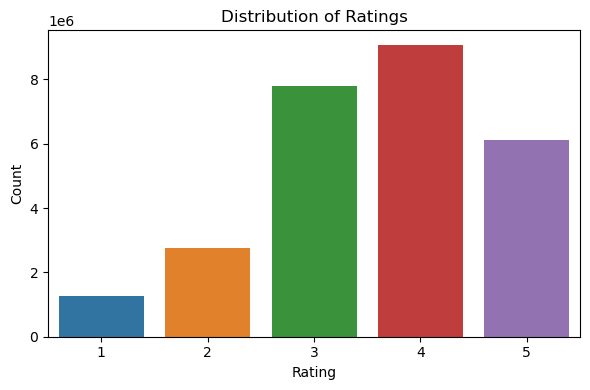

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


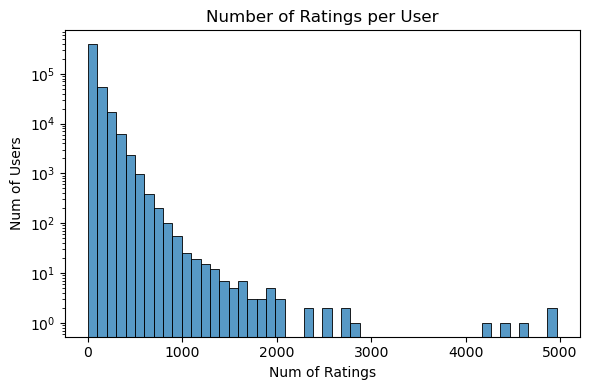

In [3]:
# EDA: basic statistics, visualize ratings
# This will help explore missing data as well

# Date column
df['date'] = pd.to_datetime(df['date'])
# Basic Statistics
print("Number of Ratings:", len(df))
print("Number of users:", df['user_id'].nunique())
print("Number of movies:", df['movie_id'].nunique())
print("Summary (Ratings):", df['rating'].describe())

# Distribution of ratings
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Ratings per user_id
user_counts = df['user_id'].value_counts()
plt.figure(figsize=(6,4))
sns.histplot(user_counts,bins=50, log_scale=(False, True))
plt.title("Number of Ratings per User")
plt.xlabel("Num of Ratings")
plt.ylabel("Num of Users")
plt.tight_layout()
plt.show()

In [10]:
# Train test split 
# Randomly select one rating from each movie for test
random.seed(13486998)
test_df = df.groupby('movie_id').apply(lambda x: x.sample(1, random_state=random.randint(0, 10**6)))
test_df = test_df.reset_index(drop=True)

# The rest of the ratings go into the training set
train_df = df.merge(test_df, on=['movie_id', 'user_id', 'rating', 'date'], how='outer', indicator=True)
train_df = train_df[train_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [14]:
movie_titles = pd.read_csv(
    "/Users/mayapanchal/Downloads/dataSet/movieTitles.csv",
    encoding='ISO-8859-1',
    header=None,
    names=["movie_id", "year", "title"]
)

# Coerce movie_id and year to numeric and drop bad rows
movie_titles['movie_id'] = pd.to_numeric(movie_titles['movie_id'], errors='coerce')
movie_titles['year'] = pd.to_numeric(movie_titles['year'], errors='coerce')
movie_titles = movie_titles.dropna(subset=['movie_id', 'year'])

movie_titles['movie_id'] = movie_titles['movie_id'].astype(int)
movie_titles['year'] = movie_titles['year'].astype(int)


train_df['movie_id'] = train_df['movie_id'].astype(int)
test_df['movie_id'] = test_df['movie_id'].astype(int)
movie_titles['movie_id'] = movie_titles['movie_id'].astype(int)

# average rating 
mean = train_df['rating'].mean()
print(f"Global Mean Rating: {mean:.4f}")

movie_mean = train_df.groupby('movie_id')['rating'].mean().rename('movie_avg')
user_mean = train_df.groupby('user_id')['rating'].mean().rename('user_avg')
movie_count = train_df.groupby('movie_id')['rating'].count().rename('movie_rating_count')
user_count = train_df.groupby('user_id')['rating'].count().rename('user_rating_count')

# Merge featueres into training
train_features = train_df.copy()
train_features = train_features.merge(movie_mean, on='movie_id', how='left')
train_features = train_features.merge(user_mean, on='user_id', how='left')
train_features = train_features.merge(movie_count, on='movie_id', how='left')
train_features = train_features.merge(user_count, on='user_id', how='left')
train_features = train_features.merge(movie_titles[['movie_id', 'year']], on='movie_id', how='left')


train_features['year'] = pd.to_numeric(train_features['year'], errors='coerce')
train_features['date'] = pd.to_datetime(train_features['date'])
train_features['rating_year'] = train_features['date'].dt.year
train_features['month'] = train_features['date'].dt.month
train_features['weekday'] = train_features['date'].dt.weekday
train_features['years_since_release'] = train_features['rating_year'] - train_features['year']

# Test set
test_features = test_df.copy()
test_features = test_features.merge(movie_mean, on='movie_id', how='left')
test_features = test_features.merge(user_mean, on='user_id', how='left')
test_features = test_features.merge(movie_count, on='movie_id', how='left')
test_features = test_features.merge(user_count, on='user_id', how='left')
test_features = test_features.merge(movie_titles[['movie_id', 'year']], on='movie_id', how='left')

test_features['year'] = pd.to_numeric(test_features['year'], errors='coerce')
test_features['date'] = pd.to_datetime(test_features['date'])
test_features['rating_year'] = test_features['date'].dt.year
test_features['month'] = test_features['date'].dt.month
test_features['weekday'] = test_features['date'].dt.weekday
test_features['years_since_release'] = test_features['rating_year'] - test_features['year']

# Fill missing values
for col in ['movie_avg', 'user_avg', 'movie_rating_count', 'user_rating_count', 'years_since_release']:
    train_features[col].fillna(mean, inplace=True)
    test_features[col].fillna(mean, inplace=True)

# Final feature set
    feature_cols = [
    'movie_avg', 'user_avg',
    'movie_rating_count', 'user_rating_count',
    'years_since_release'
]

# Build model
X_train = train_features[feature_cols]
y_train = train_features['rating']
X_test = test_features[feature_cols]
y_test = test_features['rating']


Global Mean Rating: 3.5923


In [15]:
# Build regression model that predicts the rating of a movie from a test set from the rest of the data and evaluate performance using RMSE
# Baseline Model - Linear Regression
# Train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test data
y_pred = lr.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression RMSE: {rmse:.4f}")

Linear Regression RMSE: 0.9910


In [22]:

X_train = X_train.drop(columns=['years_since_release'], errors='ignore')
X_test = X_test.drop(columns=['years_since_release'], errors='ignore')

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = ridge.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Ridge Regression RMSE (Standardized): {rmse_ridge:.4f}")


Ridge Regression RMSE (Standardized): 0.9910


Zero variance columns:
Index(['years_since_release'], dtype='object')


python(23664) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [25]:
# Random Forest Model (with some adjustments since large dataset)
rf = RandomForestRegressor(
    n_estimators=20,     # lower number of trees
    max_depth=6,         # shallower trees 
    min_samples_leaf=10, # fewer splits 
    random_state=42,
    n_jobs=-1            
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest RMSE: {rmse_rf:.4f}")


Random Forest RMSE: 0.9971


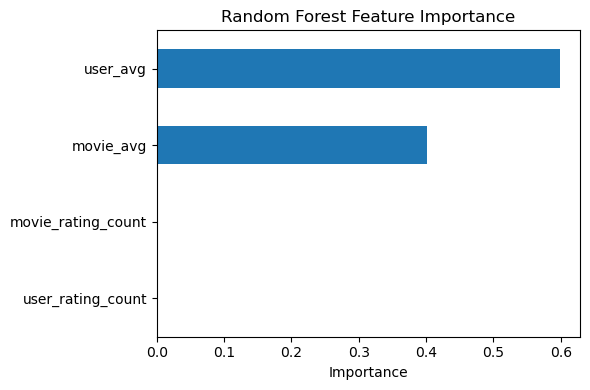

In [26]:
# Extra Credit -- feature importance 

feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

feature_importances = feature_importances.sort_values(ascending=True)

plt.figure(figsize=(6, 4))
feature_importances.plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
